In [1]:
import os
import h5py
import numpy as np

save_path = "/media/temp/DATA21/Project_FAST/CODE/MIL_CLIP_Adapter/output_CAMELYON_feat_224x224_5x_CLIP(RN50)"
for split in ['train']:
    all_patches = np.array(h5py.File(os.path.join(save_path, f"{split}_patch_feat.h5"), 'r')['dataset_1'])
    patch_corresponding_slide_label = np.load(os.path.join(save_path, f"{split}_patch_corresponding_slide_label.npy"))
    patch_corresponding_slide_index = np.load(os.path.join(save_path, f"{split}_patch_corresponding_slide_index.npy"))
    patch_corresponding_slide_name = np.load(os.path.join(save_path, f"{split}_patch_corresponding_slide_name.npy"))
    patch_label = np.load(os.path.join(save_path, f"{split}_patch_label.npy"))

    print(split)
    print(f'{split}_all_patches.shape:', all_patches.shape)
    print('\tNaN:', np.isnan(all_patches).sum())
    print(f'{split}_patch_corresponding_slide_label.shape:', patch_corresponding_slide_label.shape)
    print(f'{split}_patch_corresponding_slide_index.shape:', patch_corresponding_slide_index.shape)
    print(f'{split}_patch_corresponding_slide_name.shape:', patch_corresponding_slide_name.shape)
    print(f'{split}_patch_label.shape:', patch_label.shape)
    print()

    num_patches = all_patches.shape[0]
    num_slides = patch_corresponding_slide_index.max() + 1

    # 2. sort instances features into bag
    slide_feat_all = []
    slide_label_all = []
    slide_patch_label_all = []
    for i in range(num_slides):
        idx_from_same_slide = patch_corresponding_slide_index == i
        # print(idx_from_same_slide)
        idx_from_same_slide = np.nonzero(idx_from_same_slide)[0]
        # print(idx_from_same_slide)

        slide_feat_all.append(all_patches[idx_from_same_slide])
        if (patch_corresponding_slide_label[idx_from_same_slide].max() != 
            patch_corresponding_slide_label[idx_from_same_slide].min()):
            raise
        slide_label_all.append(patch_corresponding_slide_label[idx_from_same_slide].max())
        slide_patch_label_all.append(patch_label[idx_from_same_slide])
    print(f"[DATA INFO] num_slide is {num_slides}; num_patches is {num_patches}")
    print(f"[DATA INFO] #pos_slide is {sum(slide_label_all)}, #neg_slide is {len(slide_label_all) - sum(slide_label_all)}")

train
train_all_patches.shape: (568842, 1024)
	NaN: 0
train_patch_corresponding_slide_label.shape: (568842,)
train_patch_corresponding_slide_index.shape: (568842,)
train_patch_corresponding_slide_name.shape: (568842,)
train_patch_label.shape: (568842,)

[DATA INFO] num_slide is 251; num_patches is 568842
[DATA INFO] #pos_slide is 92, #neg_slide is 159


In [2]:
# select 32 neg slides + 32 pos slides, first 16 of each for GMM training, rest of each for dev
bag_shot = 16
slide_label_all = np.array(slide_label_all)

# pos_slide_index = np.random.choice(np.where(slide_label_all == 1)[0], bag_shot, replace=False)
# pos_slide_index = np.sort(pos_slide_index)
# assert np.all(slide_label_all[pos_slide_index] == 1)
# pos_slide_index_train = pos_slide_index
# pos_slide_index_train = np.sort(np.array([23, 202, 133, 213,  69, 201,  26,  31, 114, 148,  92,  62, 171, 83, 189,  86]))
pos_slide_index_train = np.array([224, 148])
assert np.all(slide_label_all[pos_slide_index_train] == 1)

# neg_slide_index = np.random.choice(np.where(slide_label_all == 0)[0], bag_shot, replace=False)
# neg_slide_index = np.sort(neg_slide_index)
# assert np.all(slide_label_all[neg_slide_index] == 0)
# neg_slide_index_train = neg_slide_index
neg_slide_index_train = np.array([211, 170])
assert np.all(slide_label_all[neg_slide_index_train] == 0)

In [3]:
print('Positive Slides:', pos_slide_index_train.tolist())
print('Negative Slides:', neg_slide_index_train.tolist())

Positive Slides: [224, 148]
Negative Slides: [211, 170]


In [4]:
# aggregate patch features, and train GMM for positive and negative slides

pos_slide_feat_train = np.concatenate([slide_feat_all[i] for i in pos_slide_index_train], 0)
pos_slide_label_train = np.concatenate([slide_patch_label_all[i] for i in pos_slide_index_train], 0)
assert np.any(pos_slide_feat_train)
pos_patch_ratio = pos_slide_label_train.sum() / len(pos_slide_label_train)
print(pos_slide_feat_train.shape, pos_slide_label_train.shape, f"{pos_patch_ratio:.5f}")

# pos_slide_feat_dev = np.concatenate([slide_feat_all[i] for i in pos_slide_index_dev], 0)
# pos_slide_label_dev = np.concatenate([slide_patch_label_all[i] for i in pos_slide_index_dev], 0)
# assert np.any(pos_slide_feat_dev)
# print(pos_slide_feat_dev.shape, pos_slide_label_dev.shape, f"{pos_slide_label_dev.sum() / len(pos_slide_label_dev):.5f}")

neg_slide_feat_train = np.concatenate([slide_feat_all[i] for i in neg_slide_index_train], 0)
neg_slide_label_train = np.concatenate([slide_patch_label_all[i] for i in neg_slide_index_train], 0)
assert not np.any(neg_slide_label_train)
print(neg_slide_feat_train.shape, neg_slide_label_train.shape)

# neg_slide_feat_dev = np.concatenate([slide_feat_all[i] for i in neg_slide_index_dev], 0)
# neg_slide_label_dev = np.concatenate([slide_patch_label_all[i] for i in neg_slide_index_dev], 0)
# assert not np.any(neg_slide_label_dev)
# print(neg_slide_feat_dev.shape, neg_slide_label_dev.shape)


(4108, 1024) (4108,) 0.02142
(4803, 1024) (4803,)


### GMM

In [5]:
from sklearn.mixture import GaussianMixture

n_components = 50
pos_gm = GaussianMixture(n_components=n_components, random_state=0, verbose=10, covariance_type='diag',
                         n_init=1, max_iter=100).fit(pos_slide_feat_train)
neg_gm = GaussianMixture(n_components=n_components, random_state=0, verbose=10, covariance_type='diag',
                         n_init=1, max_iter=100).fit(neg_slide_feat_train)

Initialization 0
  Iteration 10	 time lapse 1.43058s	 ll change 0.18090
  Iteration 20	 time lapse 1.24324s	 ll change 0.00003
Initialization converged: True	 time lapse 2.67390s	 ll 4083.94086
Initialization 0
  Iteration 10	 time lapse 1.95624s	 ll change 0.05153
  Iteration 20	 time lapse 1.52080s	 ll change 0.01286
Initialization converged: True	 time lapse 4.53580s	 ll 4217.41776


In [11]:
from sklearn.neighbors import KernelDensity

kde_kwargs = {
    'bandwidth': 1.0,
    'kernel': 'gaussian',
    'metric': 'euclidean',
    'algorithm': 'auto',
}
pos_gm = KernelDensity(**kde_kwargs).fit(pos_slide_feat_train)
neg_gm = KernelDensity(**kde_kwargs).fit(neg_slide_feat_train)

In [12]:
pos_slide_idx = 224
assert slide_label_all[pos_slide_idx] == 1
feat_from_pos_slide = slide_feat_all[pos_slide_idx]

pos_likelihood = pos_gm.score_samples(feat_from_pos_slide)
neg_likelihood = neg_gm.score_samples(feat_from_pos_slide)
print(pos_likelihood.shape, neg_likelihood.shape)

(1125,) (1125,)


pos likelihood selection: [  0  21  25  26  31 120 133 134 177 185 194 198 210 222 223 234] Pos Precision: 0.0625
neg likelihood selection: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] Neg Precision: 1.0000
likelihood diff selection: [  0   2   3   4   5   6  12  15  16  24  26  54  57 103 105 115] Pos Precision: 0.5000
neg likelihood selection: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16] Neg Precision: 0.9375


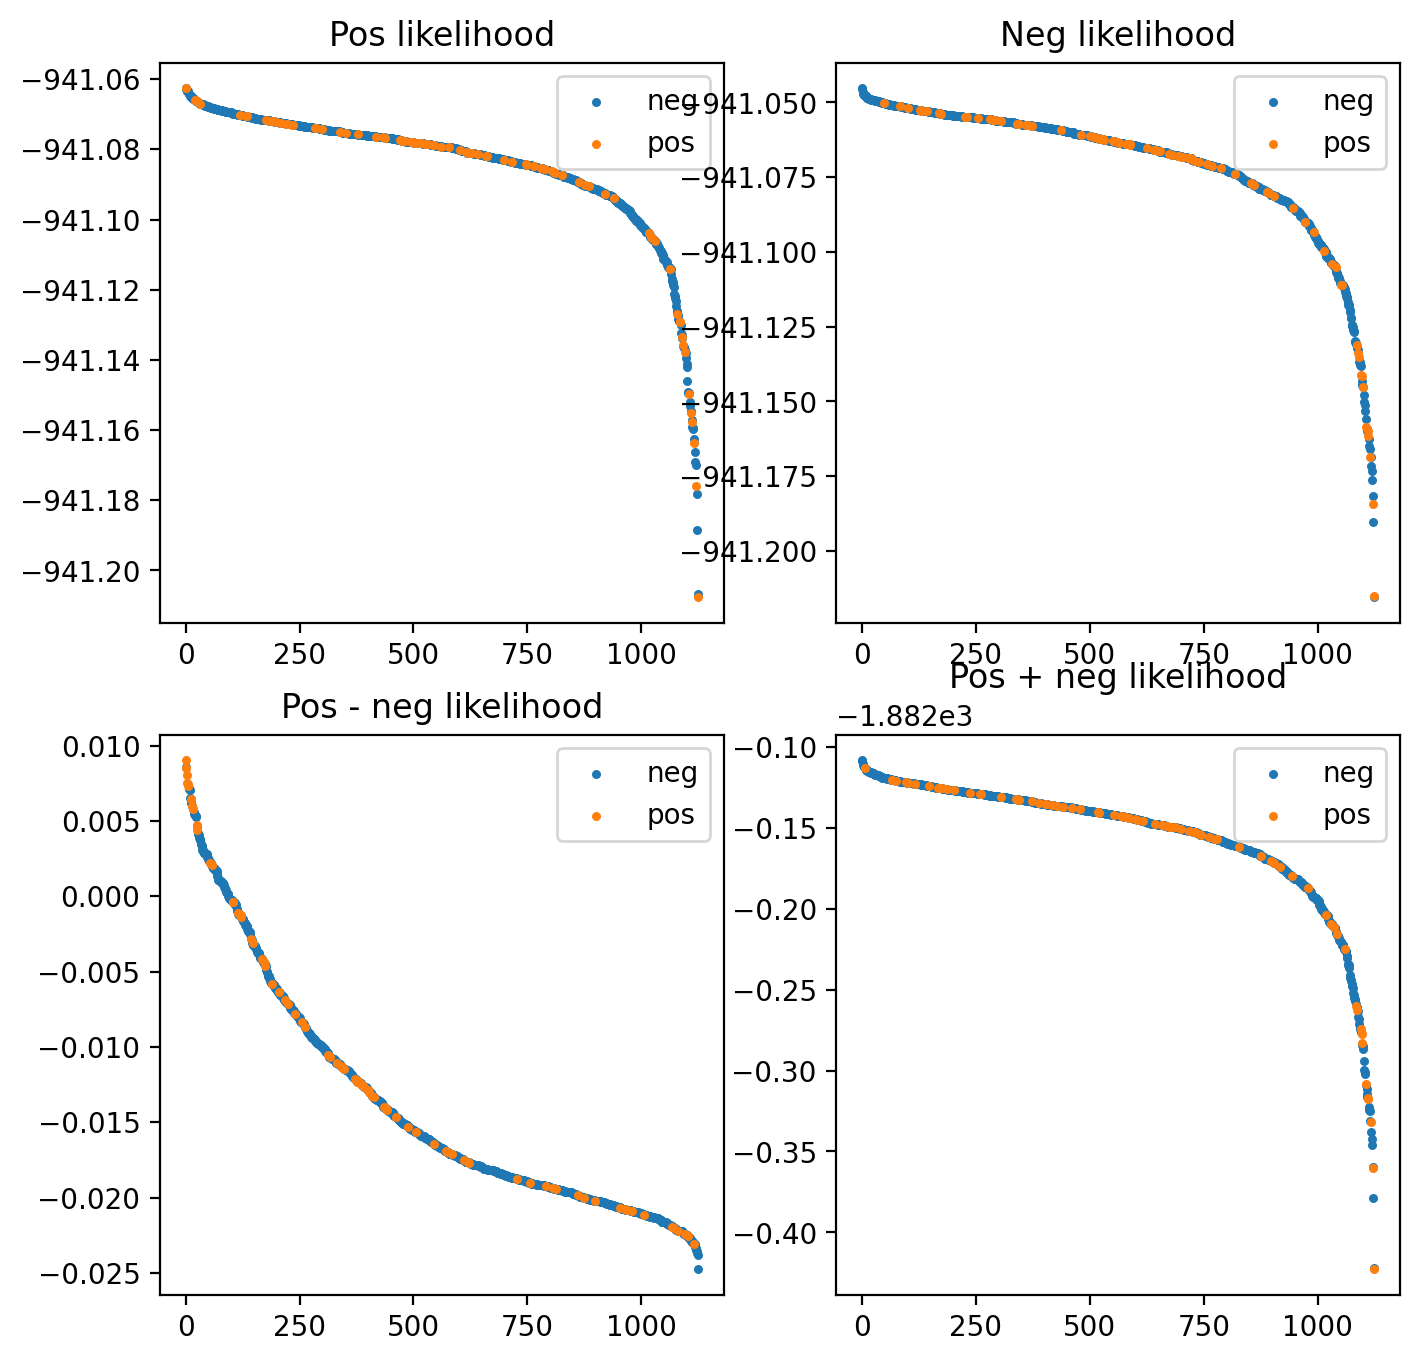

In [13]:
import matplotlib.pyplot as plt 

instance_shot = 16

x_coord = np.arange(len(pos_likelihood))

plt.figure(figsize=(8, 8), dpi=200)

slide_patch_label = slide_patch_label_all[pos_slide_idx]

#################################################################################################

plt.subplot(2, 2, 1)
pos_ll_sorted = np.sort(pos_likelihood)[::-1]
pos_ll_sorted_label = slide_patch_label[np.argsort(pos_likelihood)[::-1]]
assert np.all(pos_ll_sorted == pos_likelihood[np.argsort(pos_likelihood)[::-1]])

pos_mask = (pos_ll_sorted_label == 1)
neg_mask = (pos_ll_sorted_label == 0)
top_pos_patch_index = x_coord[pos_mask][:instance_shot]
precision_of_selected_pos_patch_posll = sum([i < instance_shot for i in top_pos_patch_index]) / instance_shot
print('pos likelihood selection:', top_pos_patch_index,  f"Pos Precision: {precision_of_selected_pos_patch_posll:.4f}")

plt.title('Pos likelihood')
plt.scatter(x_coord[neg_mask], pos_ll_sorted[neg_mask], s=5, label='neg')
plt.scatter(x_coord[pos_mask], pos_ll_sorted[pos_mask], s=5, label='pos')
plt.legend()

#################################################################################################

plt.subplot(2, 2, 2)
neg_ll_sorted = np.sort(neg_likelihood)[::-1]
neg_ll_sorted_label = slide_patch_label[np.argsort(neg_likelihood)[::-1]]
assert np.all(neg_ll_sorted == neg_likelihood[np.argsort(neg_likelihood)[::-1]])

pos_mask = (neg_ll_sorted_label == 1)
neg_mask = (neg_ll_sorted_label == 0)
top_pos_patch_index = x_coord[neg_mask][:instance_shot]
precision_of_selected_neg_patch = sum([i < instance_shot for i in top_pos_patch_index]) / instance_shot
print('neg likelihood selection:', top_pos_patch_index,  f"Neg Precision: {precision_of_selected_neg_patch:.4f}")

plt.title('Neg likelihood')
plt.scatter(x_coord[neg_mask], neg_ll_sorted[neg_mask], s=5, label='neg')
plt.scatter(x_coord[pos_mask], neg_ll_sorted[pos_mask], s=5, label='pos')
plt.legend()

#################################################################################################

plt.subplot(2, 2, 3) 
pos_patch_ll = pos_likelihood - neg_likelihood
pos_patch_ll_sorted = np.sort(pos_patch_ll)[::-1]
pos_patch_ll_sorted_label = slide_patch_label[np.argsort(pos_patch_ll)[::-1]]
assert np.all(pos_patch_ll_sorted == pos_patch_ll[np.argsort(pos_patch_ll)[::-1]])

pos_mask = (pos_patch_ll_sorted_label == 1)
neg_mask = (pos_patch_ll_sorted_label == 0)
top_pos_patch_index = x_coord[pos_mask][:instance_shot]
precision_of_selected_pos_patch = sum([i < instance_shot for i in top_pos_patch_index]) / instance_shot
print('likelihood diff selection:', top_pos_patch_index,  f"Pos Precision: {precision_of_selected_pos_patch:.4f}")

plt.title('Pos - neg likelihood')
plt.scatter(x_coord[neg_mask], pos_patch_ll_sorted[neg_mask], s=5, label='neg')
plt.scatter(x_coord[pos_mask], pos_patch_ll_sorted[pos_mask], s=5, label='pos')
plt.legend()

#################################################################################################

plt.subplot(2, 2, 4)
neg_patch_ll = pos_likelihood + neg_likelihood
neg_patch_ll_sorted = np.sort(neg_patch_ll)[::-1]
neg_patch_ll_sorted_label = slide_patch_label[np.argsort(neg_patch_ll)[::-1]]
assert np.all(neg_patch_ll_sorted == neg_patch_ll[np.argsort(neg_patch_ll)[::-1]])

pos_mask = (neg_patch_ll_sorted_label == 1)
neg_mask = (neg_patch_ll_sorted_label == 0)
top_pos_patch_index = x_coord[neg_mask][:instance_shot]
precision_of_selected_neg_patch = sum([i < instance_shot for i in top_pos_patch_index]) / instance_shot
print('neg likelihood selection:', top_pos_patch_index,  f"Neg Precision: {precision_of_selected_neg_patch:.4f}")

plt.title('Pos + neg likelihood')
plt.scatter(x_coord[neg_mask], neg_patch_ll_sorted[neg_mask], s=5, label='neg')
plt.scatter(x_coord[pos_mask], neg_patch_ll_sorted[pos_mask], s=5, label='pos')
plt.legend()
plt.show()

### T-SNE

In [32]:
import torch
import torch.nn as nn 
import torch.nn.functional as F 
from sklearn.manifold import TSNE

feat_train = torch.tensor(pos_slide_feat_train).cuda()
dist_mat_gpu = torch.cdist(feat_train, feat_train)
dist_mat_cpu = dist_mat_gpu.cpu().numpy()
del dist_mat_gpu

tsne = TSNE(n_components=2, metric='precomputed', init="random", verbose=10, n_jobs=-1).fit(dist_mat_cpu)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4108 samples in 0.009s...
[t-SNE] Computed neighbors for 4108 samples in 0.136s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4108
[t-SNE] Computed conditional probabilities for sample 2000 / 4108
[t-SNE] Computed conditional probabilities for sample 3000 / 4108
[t-SNE] Computed conditional probabilities for sample 4000 / 4108
[t-SNE] Computed conditional probabilities for sample 4108 / 4108
[t-SNE] Mean sigma: 0.064192
[t-SNE] Computed conditional probabilities in 0.054s
[t-SNE] Iteration 50: error = 85.2493668, gradient norm = 0.0190530 (50 iterations in 0.189s)
[t-SNE] Iteration 100: error = 74.5850906, gradient norm = 0.0055409 (50 iterations in 0.180s)
[t-SNE] Iteration 150: error = 74.0878143, gradient norm = 0.0017843 (50 iterations in 0.176s)
[t-SNE] Iteration 200: error = 73.9493866, gradient norm = 0.0010062 (50 iterations in 0.167s)
[t-SNE] Iteration 250: error = 73.8848114, gradient norm = 0.0007596

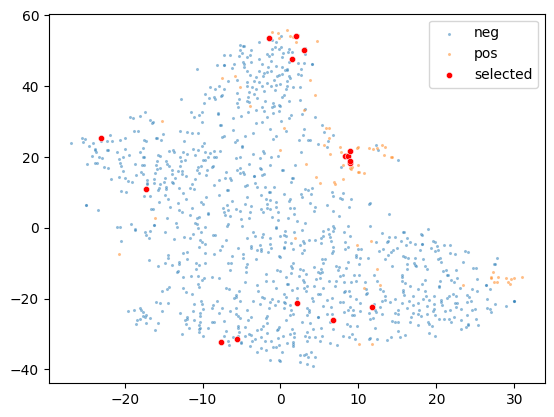

In [15]:
import seaborn as sns

pos_mask = (pos_slide_label_train == 1)
neg_mask = (pos_slide_label_train == 0)

selected_idx = torch.topk(torch.tensor(pos_patch_ll), k=instance_shot)[1].cpu().numpy()

sns.scatterplot(x=tsne[neg_mask, 0], y=tsne[neg_mask, 1], label='neg', s=5, alpha=0.5)
sns.scatterplot(x=tsne[pos_mask, 0], y=tsne[pos_mask, 1], label='pos', s=5, alpha=0.5)
sns.scatterplot(x=tsne[selected_idx, 0], y=tsne[selected_idx, 1], label='selected', c='red', s=20, alpha=1.0)

plt.legend()
plt.show()

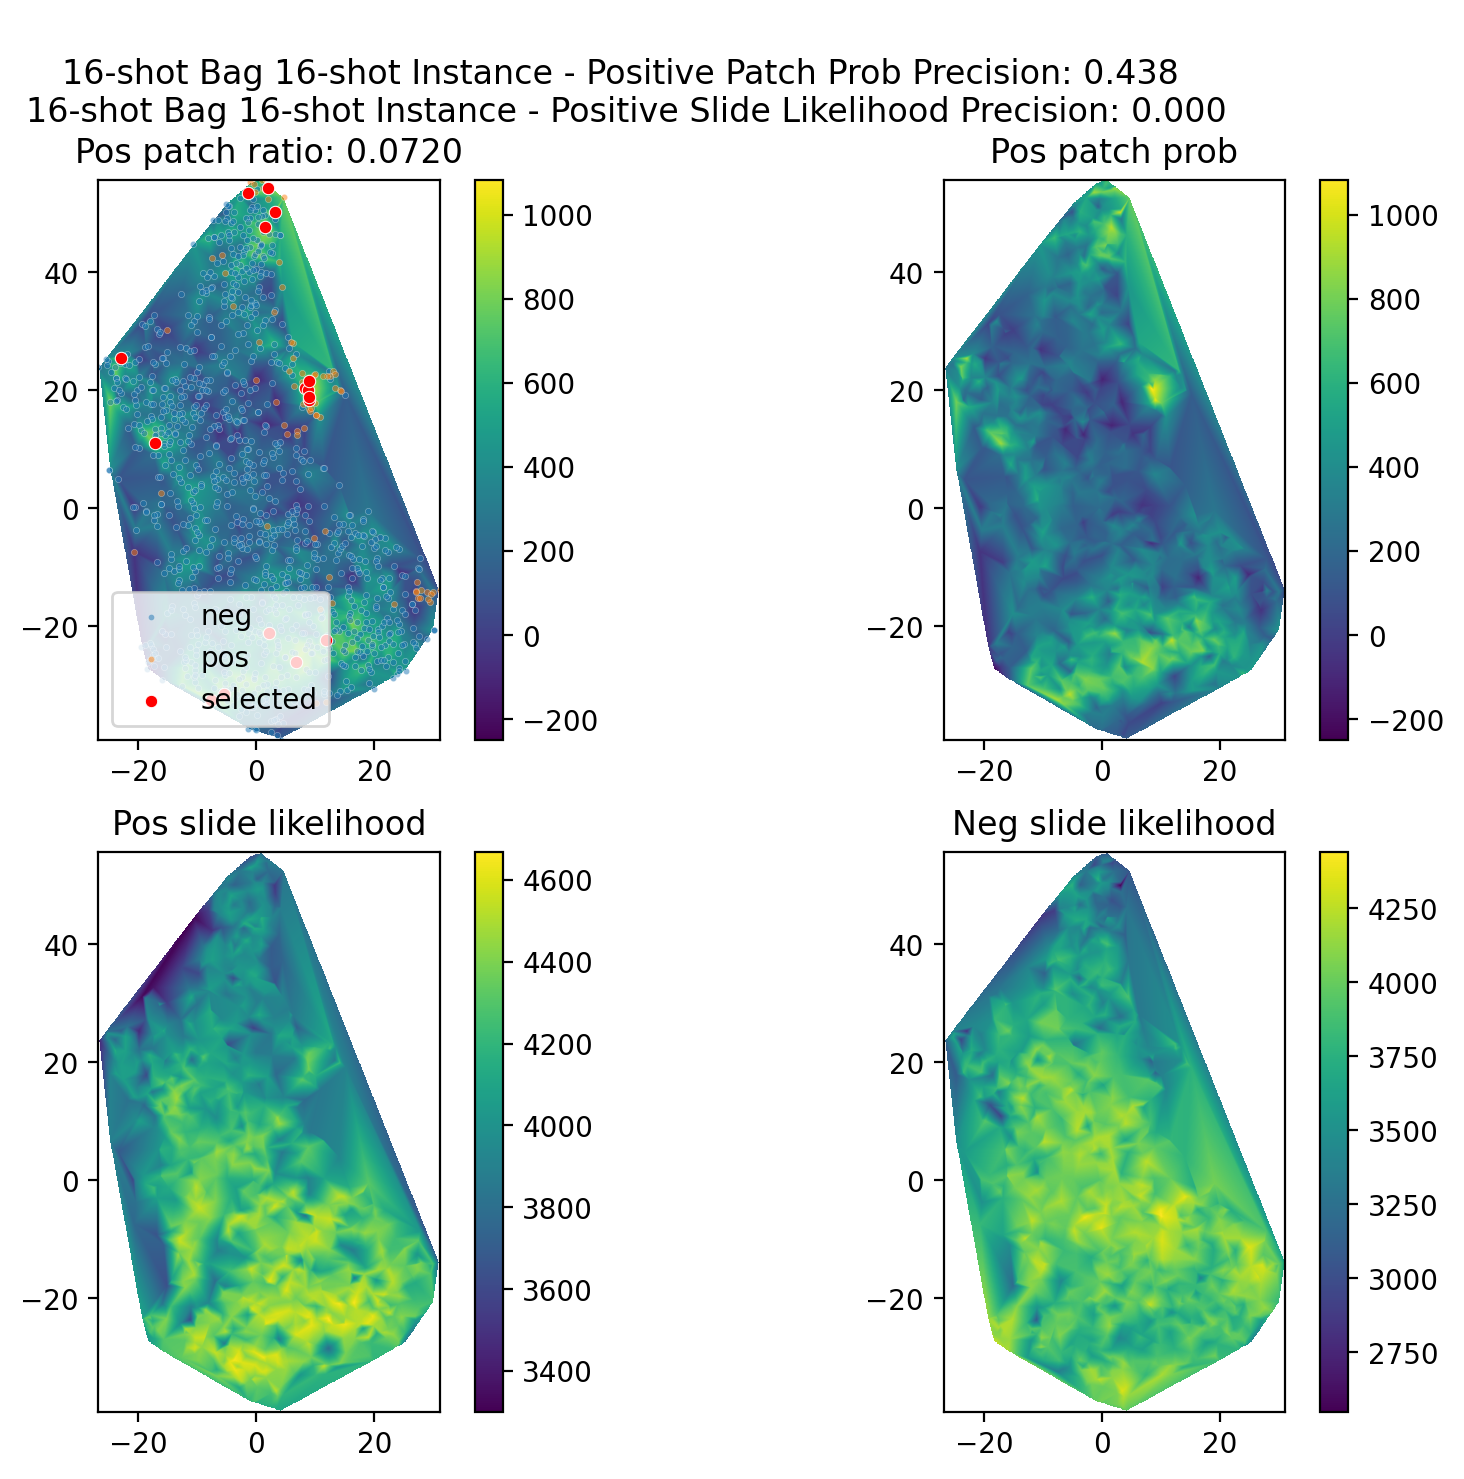

In [17]:
from scipy.interpolate import griddata
xi = np.linspace(min(tsne[:, 0]), max(tsne[:, 0]), 1000)
yi = np.linspace(min(tsne[:, 1]), max(tsne[:, 1]), 1000)
X, Y = np.meshgrid(xi, yi)
Z_pos_patch = griddata((tsne[:, 0], tsne[:, 1]), pos_patch_ll, (X, Y), method='linear')
Z_pos_ll = griddata((tsne[:, 0], tsne[:, 1]), pos_likelihood_from_pos_slide_train, (X, Y), method='linear')
Z_neg_ll = griddata((tsne[:, 0], tsne[:, 1]), pos_likelihood_from_neg_slide_train, (X, Y), method='linear')

plt.figure(figsize=(10, 8), dpi=200)

plt.suptitle(f"""
{bag_shot}-shot Bag {instance_shot}-shot Instance - Positive Patch Prob Precision: {precision_of_selected_pos_patch:.3f} 
{bag_shot}-shot Bag {instance_shot}-shot Instance - Positive Slide Likelihood Precision: {precision_of_selected_pos_patch_posll:.3f}""")

plt.subplot(2, 2, 1)
plt.title(f'Pos patch ratio: {pos_patch_ratio:.4f}')
sns.scatterplot(x=tsne[neg_mask, 0], y=tsne[neg_mask, 1], label='neg', s=5, alpha=0.5)
sns.scatterplot(x=tsne[pos_mask, 0], y=tsne[pos_mask, 1], label='pos', s=5, alpha=0.5)
sns.scatterplot(x=tsne[selected_idx, 0], y=tsne[selected_idx, 1], label='selected', c='red', s=20, alpha=1.0)
plt.imshow(Z_pos_patch, extent=(min(tsne[:, 0]), max(tsne[:, 0]), min(tsne[:, 1]), max(tsne[:, 1])), origin='lower')
plt.legend(loc='lower left')
plt.colorbar()

plt.subplot(2, 2, 2)
plt.title('Pos patch prob')
plt.imshow(Z_pos_patch, extent=(min(tsne[:, 0]), max(tsne[:, 0]), min(tsne[:, 1]), max(tsne[:, 1])), origin='lower')
plt.colorbar()

plt.subplot(2, 2, 3)
plt.title('Pos slide likelihood')
plt.imshow(Z_pos_ll, extent=(min(tsne[:, 0]), max(tsne[:, 0]), min(tsne[:, 1]), max(tsne[:, 1])), origin='lower')
plt.colorbar()

plt.subplot(2, 2, 4)
plt.title('Neg slide likelihood')
plt.imshow(Z_neg_ll, extent=(min(tsne[:, 0]), max(tsne[:, 0]), min(tsne[:, 1]), max(tsne[:, 1])), origin='lower')
plt.colorbar()

plt.show()